## Phase calculation: simple example ##

Using gradient descent with momentum

### Sam's notes ###

### Tiff's notes ###
 - Also want a conjugate gradient version!
 - Currently just has a uniform S (laser field) - a very easy improvement will be to use a more realistic version (either a large Gaussian or an image of the real beam) - could either generate here or write a file with the targets (though not really necessary to produce a new file each time!)
 - fftshift completely omitted - but will be easy to include!
 - as in regions, would be good to extract target info from file names (or a useful text file in the folder) rather than entering manually
 - at the moment, running for a defined number of iterations - would be useful to keep going until it stagnates
 - Naming conventions for folders: need to find a good system otherwise things get very confusing very fast! Include everything to be able to get back to this result: random seed, cost function, number of iterations etc

### Preamble; loading target and weighting arrays ###

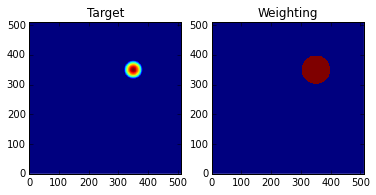

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import theano

%matplotlib inline


# decide what target you want:
targetdir = 'initialisation/example_power2_512_(350,350)_64/'
targetname = os.path.join(targetdir, 'target.dat')
# decide what weighting arrays to use:
weightingdir = os.path.join(targetdir, 'weighting_border_16_noise_1e-06/')
weightingname = os.path.join(weightingdir, 'weight.dat')


target = np.loadtxt(targetname)
weighting = np.loadtxt(weightingname)

N = target.shape[0]/2  # size of SLM is NxN (assuming that padding has doubled size here)

plot_args = {'extent':[0, 2*N, 0, 2*N],
             'interpolation':'None',
             'origin': 'lower'}

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(target, vmin=0, vmax=1, **plot_args)
axes[0].set_title('Target')
axes[1].imshow(weighting, vmin=0, vmax=1, **plot_args)
axes[1].set_title('Weighting')

In [16]:
# Initialise SLM optimisation class:
import slm
import theano
import theano.tensor as T

# the code to set up the computation graph transforming the phases
# into an intensity field lives in the slmOptimisation class.
from slm import slmOptimisation

# initialise the phase:
def initial_phase(N):
    """ Return a randomised phase array over [0, 2pi]
    """
    return np.random.uniform(low=0, high=2*np.pi, size=(N,N)).astype(theano.config.floatX)

init_phi = initial_phase(N)

# for this example, the profile $S_{nm}$ is uniform.
s_profile_r = np.ones_like(init_phi).astype(theano.config.floatX)
s_profile_i = np.ones_like(init_phi).astype(theano.config.floatX)
mat_zeros = np.zeros((2*N, 2*N), dtype=theano.config.floatX)

slmOpt = slmOptimisation(target, init_phi, A0=1.0/1000) # fudge factor! Need to stabilise this...

This is the crucial part, where we define the __cost__ function. Here we simply take the difference between the reconstruction and the target, square and sum.  Differentiation of this cost function happens automatically further downstream.
$$ C = \sum_{nm} (T_{nm} - |E^{out}_{nm}|^2)^2 $$

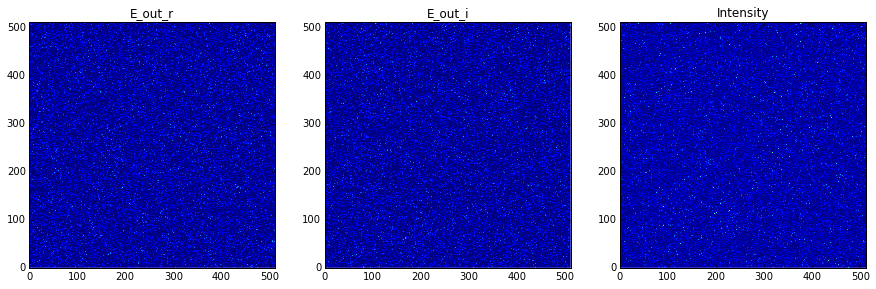

In [17]:
# we now define a cost function to use, squared error for now.
cost = T.sum(T.pow(slmOpt.E_out_2 - target, 2))

# compile a function to calculate cost
f_cost = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], cost, on_unused_input='warn')
f_cost(s_profile_r, s_profile_i, mat_zeros)

# compile field output functions:
f_E_out = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], [slmOpt.E_out_r, slmOpt.E_out_i], on_unused_input='warn')
f_E_out_2 = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], slmOpt.E_out_2, on_unused_input='warn')

# visualise the output given the initial phi field
E_out = f_E_out(s_profile_r, s_profile_i, mat_zeros)
E2_out = f_E_out_2(s_profile_r, s_profile_i, mat_zeros)

fig, (ax1a, ax1b, ax2) = plt.subplots(ncols=3, figsize=(15,15))
ax1a.imshow(E_out[0], vmin=0, vmax=3, **plot_args)
ax1a.set_title('E_out_r')
ax1b.imshow(E_out[1], vmin=0, vmax=3, **plot_args)
ax1b.set_title('E_out_i')
ax2.imshow(E2_out, vmin=0, vmax=3, **plot_args)
ax2.set_title('Intensity');

In [18]:
# create symbolic gradient
grad = T.grad(cost, wrt=slmOpt.phi)

# and define a simple momentum update scheme (as a graph)
l_rate = 0.01   # 'learning rate'
momentum = 0.95 # momentum decay
updates = ((slmOpt.phi, slmOpt.phi - l_rate * slmOpt.phi_rate),
           (slmOpt.phi_rate, momentum*slmOpt.phi_rate + (1.-momentum)*grad))

# now actually compile a function to evaluate this gradient:
print "Compiling update function..."
update = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], 
                         cost, 
                         updates=updates,
                         on_unused_input='warn')
print "...done"

C = update(s_profile_r, s_profile_i, mat_zeros)

Compiling update function...
...done


Perform N steps of gradient descent with momentum, and plot.

NB you can press Shift + Enter repeatedly on this cell to incrementally
perform the gradient descent.

Initial C: 5023.8898094
0 5.02e+03
100 5.02e+03
200 5.02e+03
300 5.02e+03
400 5.02e+03
500 5.02e+03
600 5.02e+03
700 5.02e+03
800 5.02e+03
900 5.01e+03
1000 5.01e+03
1100 5.01e+03
1200 5.01e+03
1300 5.01e+03
1400 5.01e+03
1500 5.01e+03
1600 5.01e+03
1700 5.01e+03
1800 5.01e+03
1900 5.01e+03
2000 5.00e+03
2100 5.00e+03
2200 5.00e+03
2300 5.00e+03
2400 5.00e+03
2500 5.00e+03
2600 5.00e+03
2700 5.00e+03
2800 5.00e+03
2900 5.00e+03
3000 5.00e+03
3100 5.00e+03
3200 4.99e+03
3300 4.99e+03
3400 4.99e+03
3500 4.99e+03
3600 4.99e+03
3700 4.99e+03
3800 4.99e+03
3900 4.99e+03
4000 4.99e+03
4100 4.99e+03
4200 4.99e+03
4300 4.99e+03
4400 4.99e+03
4500 4.99e+03
4600 4.98e+03
4700 4.98e+03
4800 4.98e+03
4900 4.98e+03
5000 4.98e+03
5100 4.98e+03
5200 4.98e+03
5300 4.98e+03
5400 4.98e+03
5500 4.98e+03
5600 4.98e+03
5700 4.98e+03
5800 4.98e+03
5900 4.98e+03
6000 4.98e+03
6100 4.98e+03
6200 4.97e+03
6300 4.97e+03
6400 4.97e+03
6500 4.97e+03
6600 4.97e+03
6700 4.97e+03
6800 4.97e+03
6900 4.97e+03
7000 4.9

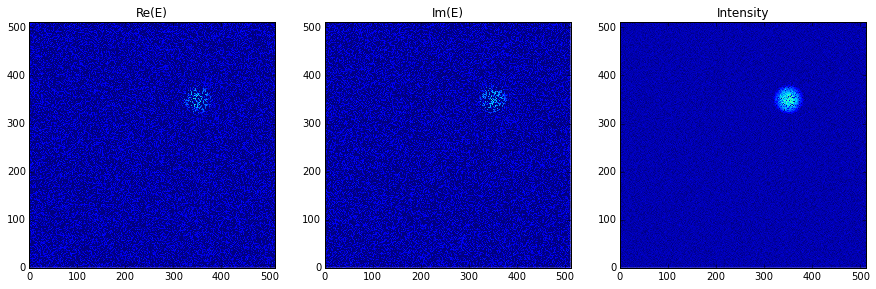

In [21]:
N_steps = 10000
print 'Initial C: {}'.format(C)
last_C = C
n = 0
for n in range(N_steps):
    C = update(s_profile_r, s_profile_i, mat_zeros)
    if np.mod(n, 100) == 0:
        print '{:d} {:.2e}'.format(n, float(C))

# make plots
E_out = f_E_out(s_profile_r, s_profile_i, mat_zeros)
E2_out = f_E_out_2(s_profile_r, s_profile_i, mat_zeros)

fig, (ax1a, ax1b, ax2) = plt.subplots(ncols=3, figsize=(15,15))
ax1a.imshow(E_out[0], vmin=0, vmax=3, **plot_args)
ax1a.set_title('Re(E)')
ax1b.imshow(E_out[1], vmin=0, vmax=3, **plot_args)
ax1b.set_title('Im(E)')
ax2.imshow(E2_out, vmin=0, vmax=3, **plot_args)
ax2.set_title('Intensity');

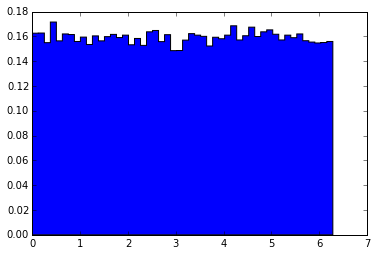

In [22]:
# Check the phase field is sane:
input_phi = np.mod(slmOpt.phi.get_value(), 2*np.pi)
n, bins, patches = plt.hist(input_phi.flatten(), 50, normed=1, histtype='stepfilled')

testdir = os.path.join(weightingdir, 'testcost1/') # Use a more useful naming convention!
if not os.path.exists(testdir):
    os.makedirs(testdir)

# Save the phase field:
np.savetxt(os.path.join(testdir, 'phi'), input_phi)

# Save the calculated output
np.savetxt(os.path.join(testdir, 'intensity'), E2_out)

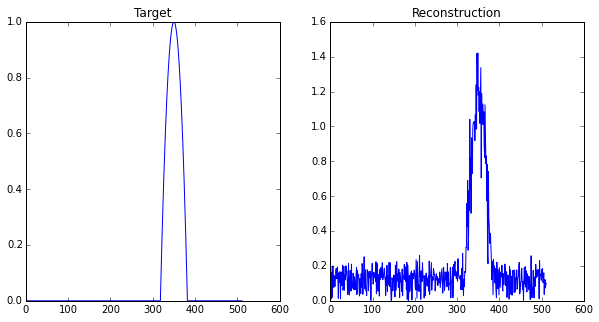

In [23]:
# Plot a cross-section through
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].plot(target[350,:])
axes[0].set_title('Target')
axes[1].plot(E2_out[350,:])
axes[1].set_title('Reconstruction')

This is a rather poor reconstruction - vortices everywhere!